<a href="https://colab.research.google.com/github/EmiliaNahapetyan/CNN_homework/blob/main/YOLO_PascalVOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
import torch
print(f"CUDA. {torch.cuda.is_available()}")
print(f"GPU. {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 28.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import shutil
import xml.etree.ElementTree as ET

base_dir = '/content/VOC'
os.makedirs(os.path.join(base_dir, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'labels', 'val'), exist_ok=True)

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

VOC_CLASSES = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
               'train', 'tvmonitor']

def convert_coordinates(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

def convert_annotation(image_id, data_type):
    in_file_path = os.path.join('VOCdevkit/VOC2012/Annotations', f'{image_id}.xml')
    out_file_path = os.path.join(base_dir, 'labels', data_type, f'{image_id}.txt')

    tree = ET.parse(in_file_path)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    with open(out_file_path, 'w') as out_file:
        for obj in root.iter('object'):
            difficult = obj.find('difficult')
            if difficult is not None and int(difficult.text) == 1:
                continue
            cls = obj.find('name').text
            if cls not in VOC_CLASSES:
                continue
            cls_id = VOC_CLASSES.index(cls)
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            bb = convert_coordinates((w, h), b)
            out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")

!cat VOCdevkit/VOC2012/ImageSets/Main/train.txt > train.txt
!cat VOCdevkit/VOC2012/ImageSets/Main/val.txt > val.txt

print("Converting the Train dataset.")
with open('train.txt', 'r') as f:
    train_ids = [line.strip() for line in f.readlines()]
for image_id in train_ids:
    convert_annotation(image_id, 'train')
    shutil.copy(os.path.join('VOCdevkit/VOC2012/JPEGImages', f'{image_id}.jpg'),
                os.path.join(base_dir, 'images', 'train', f'{image_id}.jpg'))

print("Converting the Val dataset.")
with open('val.txt', 'r') as f:
    val_ids = [line.strip() for line in f.readlines()]
for image_id in val_ids:
    convert_annotation(image_id, 'val')
    shutil.copy(os.path.join('VOCdevkit/VOC2012/JPEGImages', f'{image_id}.jpg'),
                os.path.join(base_dir, 'images', 'val', f'{image_id}.jpg'))

print("The dataset is prepared.")

shutil.move(base_dir, '/content/gdrive/MyDrive/YOLOv8_VOC_Dataset')

--2025-05-26 18:01:09--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  20.7MB/s    in 1m 49s  

2025-05-26 18:02:59 (17.5 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]

Converting the Train dataset.
Converting the Val dataset.
The dataset is prepared.


'/content/gdrive/MyDrive/YOLOv8_VOC_Dataset'

In [4]:
%%writefile voc.yaml
path: /content/gdrive/MyDrive/YOLOv8_VOC_Dataset
train: images/train
val: images/val

nc: 20
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
        'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
        'train', 'tvmonitor']

Writing voc.yaml


In [6]:
from ultralytics import YOLO

model = YOLO('yolov8m.pt')

results = model.train(data='voc.yaml', epochs=30, imgsz=640, batch=16,
                      optimizer='AdamW', lr0=0.001, lrf=0.01, patience=10,
                      project='YOLOv8_VOC_FineTune', name='YOLOv8n_PascalVOC',
                      cache=True)

shutil.copy('/content/YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC/weights/best.pt', '/content/gdrive/MyDrive/YOLOv8_VOC_FineTune/best.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 271MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=YOLOv8n_PascalVOC, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

100%|██████████| 755k/755k [00:00<00:00, 24.7MB/s]

Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  2   1846272  ultralytics.nn.modules.block.C2f             [576, 384, 2]                 
 19                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 1.1±1.3 ms, read: 59.7±44.1 MB/s, size: 102.7 KB)


train: Scanning /content/gdrive/MyDrive/YOLOv8_VOC_Dataset/labels/train... 5717 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5717/5717 [01:44<00:00, 54.86it/s] 


train: New cache created: /content/gdrive/MyDrive/YOLOv8_VOC_Dataset/labels/train.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (4.8GB RAM): 100%|██████████| 5717/5717 [00:40<00:00, 139.58it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 21.1±10.3 MB/s, size: 122.7 KB)


val: Scanning /content/gdrive/MyDrive/YOLOv8_VOC_Dataset/labels/val... 5823 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5823/5823 [01:53<00:00, 51.41it/s] 


val: New cache created: /content/gdrive/MyDrive/YOLOv8_VOC_Dataset/labels/val.cache
WARNING ⚠️ val: 7.1GB RAM required to cache images with 50% safety margin but only 4.5/12.7GB available, not caching images
Plotting labels to YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.18G      1.089      1.862      1.396         28        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:26<00:00,  2.10it/s]


                   all       5823      13841      0.412      0.322      0.278      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.49G      1.306      2.136      1.581         22        640: 100%|██████████| 358/358 [03:14<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


                   all       5823      13841      0.367      0.319      0.267      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.47G      1.338      2.141      1.612         18        640: 100%|██████████| 358/358 [03:13<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:27<00:00,  2.08it/s]


                   all       5823      13841      0.422      0.345      0.313       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.37G      1.267      2.002      1.563         25        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:23<00:00,  2.19it/s]


                   all       5823      13841        0.5      0.405      0.404      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.46G      1.189      1.832      1.511         21        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:23<00:00,  2.19it/s]


                   all       5823      13841      0.532      0.448      0.457      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.37G      1.151      1.743      1.476         25        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:23<00:00,  2.19it/s]


                   all       5823      13841      0.575      0.503      0.518      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.46G      1.095      1.615      1.441         18        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:17<00:00,  2.34it/s]


                   all       5823      13841      0.629      0.528      0.568      0.377

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.36G      1.073      1.529      1.417         44        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:22<00:00,  2.20it/s]


                   all       5823      13841      0.639      0.529      0.576      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.45G      1.036      1.451      1.389         17        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:17<00:00,  2.34it/s]


                   all       5823      13841      0.671      0.559      0.615      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.36G       1.01      1.387      1.371         19        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:21<00:00,  2.23it/s]


                   all       5823      13841      0.666      0.568      0.618      0.424

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.44G     0.9904       1.34      1.363         20        640: 100%|██████████| 358/358 [03:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.31it/s]


                   all       5823      13841        0.7      0.585      0.646      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.31G     0.9658      1.279      1.339         29        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:19<00:00,  2.28it/s]


                   all       5823      13841      0.705      0.599      0.666       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.46G     0.9514      1.219      1.328         24        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.32it/s]


                   all       5823      13841      0.693        0.6      0.653      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.37G     0.9278      1.187      1.304         30        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.33it/s]


                   all       5823      13841      0.717       0.61      0.671      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.46G      0.905      1.136      1.288         25        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:19<00:00,  2.28it/s]


                   all       5823      13841      0.724      0.616       0.68      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.35G     0.8811      1.094      1.277         36        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.30it/s]


                   all       5823      13841      0.731      0.637      0.697      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.45G      0.867      1.049      1.258         26        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.33it/s]


                   all       5823      13841      0.741       0.63      0.702      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      6.35G     0.8558      1.013      1.249         19        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.33it/s]


                   all       5823      13841      0.734      0.632      0.704      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.45G     0.8421     0.9788      1.241         32        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:17<00:00,  2.33it/s]


                   all       5823      13841      0.753      0.653      0.721      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.37G     0.8217     0.9444      1.227         44        640: 100%|██████████| 358/358 [03:11<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:19<00:00,  2.30it/s]

                   all       5823      13841      0.769      0.644      0.721       0.53


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.46G     0.7881     0.8279      1.201         14        640: 100%|██████████| 358/358 [03:12<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.32it/s]


                   all       5823      13841      0.743      0.634      0.701      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.36G     0.7648     0.7676      1.191          9        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:18<00:00,  2.33it/s]


                   all       5823      13841      0.733       0.65      0.709      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.43G     0.7431     0.7315      1.171         16        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:17<00:00,  2.34it/s]


                   all       5823      13841      0.771      0.648      0.726      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.34G     0.7176      0.684      1.143         26        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:19<00:00,  2.30it/s]

                   all       5823      13841      0.766      0.663      0.733      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.44G     0.6958     0.6435      1.128         14        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:17<00:00,  2.36it/s]

                   all       5823      13841      0.769      0.666      0.732      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.36G     0.6724     0.5976      1.115         17        640: 100%|██████████| 358/358 [03:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:16<00:00,  2.37it/s]

                   all       5823      13841      0.783      0.663      0.743      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.44G     0.6525     0.5689      1.093          9        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:16<00:00,  2.37it/s]


                   all       5823      13841      0.783      0.667      0.743      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.38G     0.6332     0.5365      1.076         11        640: 100%|██████████| 358/358 [03:08<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:16<00:00,  2.38it/s]

                   all       5823      13841      0.795      0.672      0.749      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.45G     0.6172     0.5074      1.062         18        640: 100%|██████████| 358/358 [03:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:15<00:00,  2.40it/s]

                   all       5823      13841      0.786      0.676      0.754      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.36G     0.6019     0.4856      1.056         11        640: 100%|██████████| 358/358 [03:09<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:16<00:00,  2.39it/s]


                   all       5823      13841      0.779      0.689      0.755      0.576

30 epochs completed in 2.383 hours.
Optimizer stripped from YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC/weights/last.pt, 52.0MB
Optimizer stripped from YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC/weights/best.pt, 52.0MB

Validating YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,851,340 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 182/182 [01:19<00:00,  2.28it/s]


                   all       5823      13841      0.779      0.688      0.755      0.576
             aeroplane        343        433      0.881      0.767      0.838      0.696
               bicycle        284        358      0.857      0.722       0.81      0.634
                  bird        370        559      0.815      0.698       0.78      0.566
                  boat        248        424      0.694      0.502      0.606      0.386
                bottle        341        630      0.775      0.541      0.637       0.44
                   bus        208        301      0.877      0.801      0.875      0.759
                   car        571       1004      0.855      0.747      0.833      0.632
                   cat        541        612       0.87      0.808      0.889      0.721
                 chair        553       1176      0.732      0.512      0.621      0.437
                   cow        152        298      0.648      0.685       0.71       0.55
           diningtabl

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/YOLOv8_VOC_FineTune/best.pt'

📷 Showing: results.png


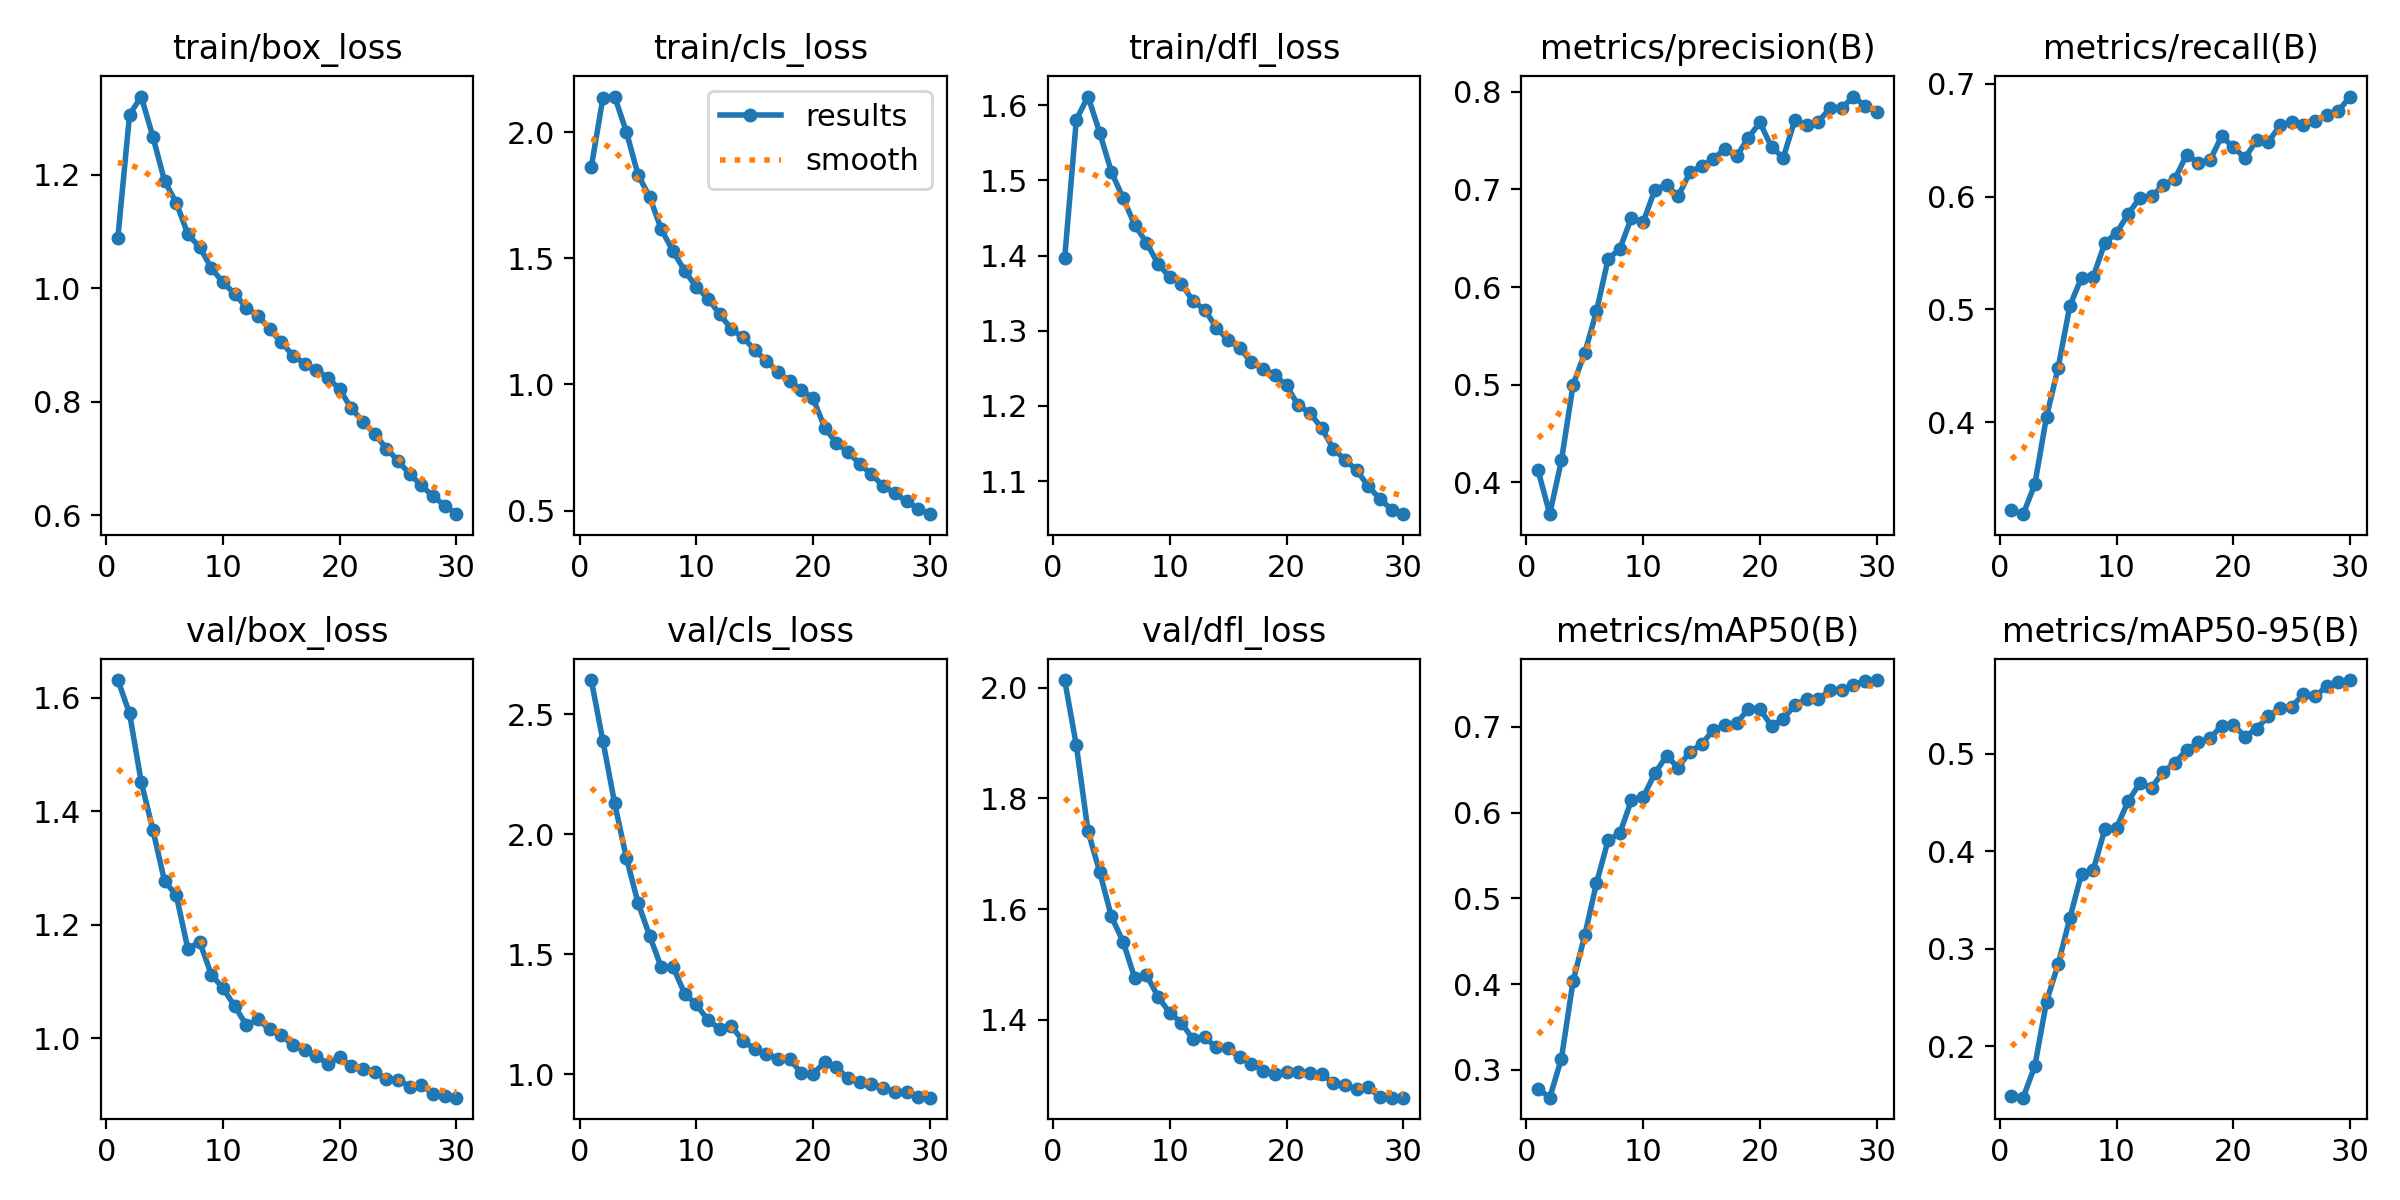

📷 Showing: confusion_matrix.png


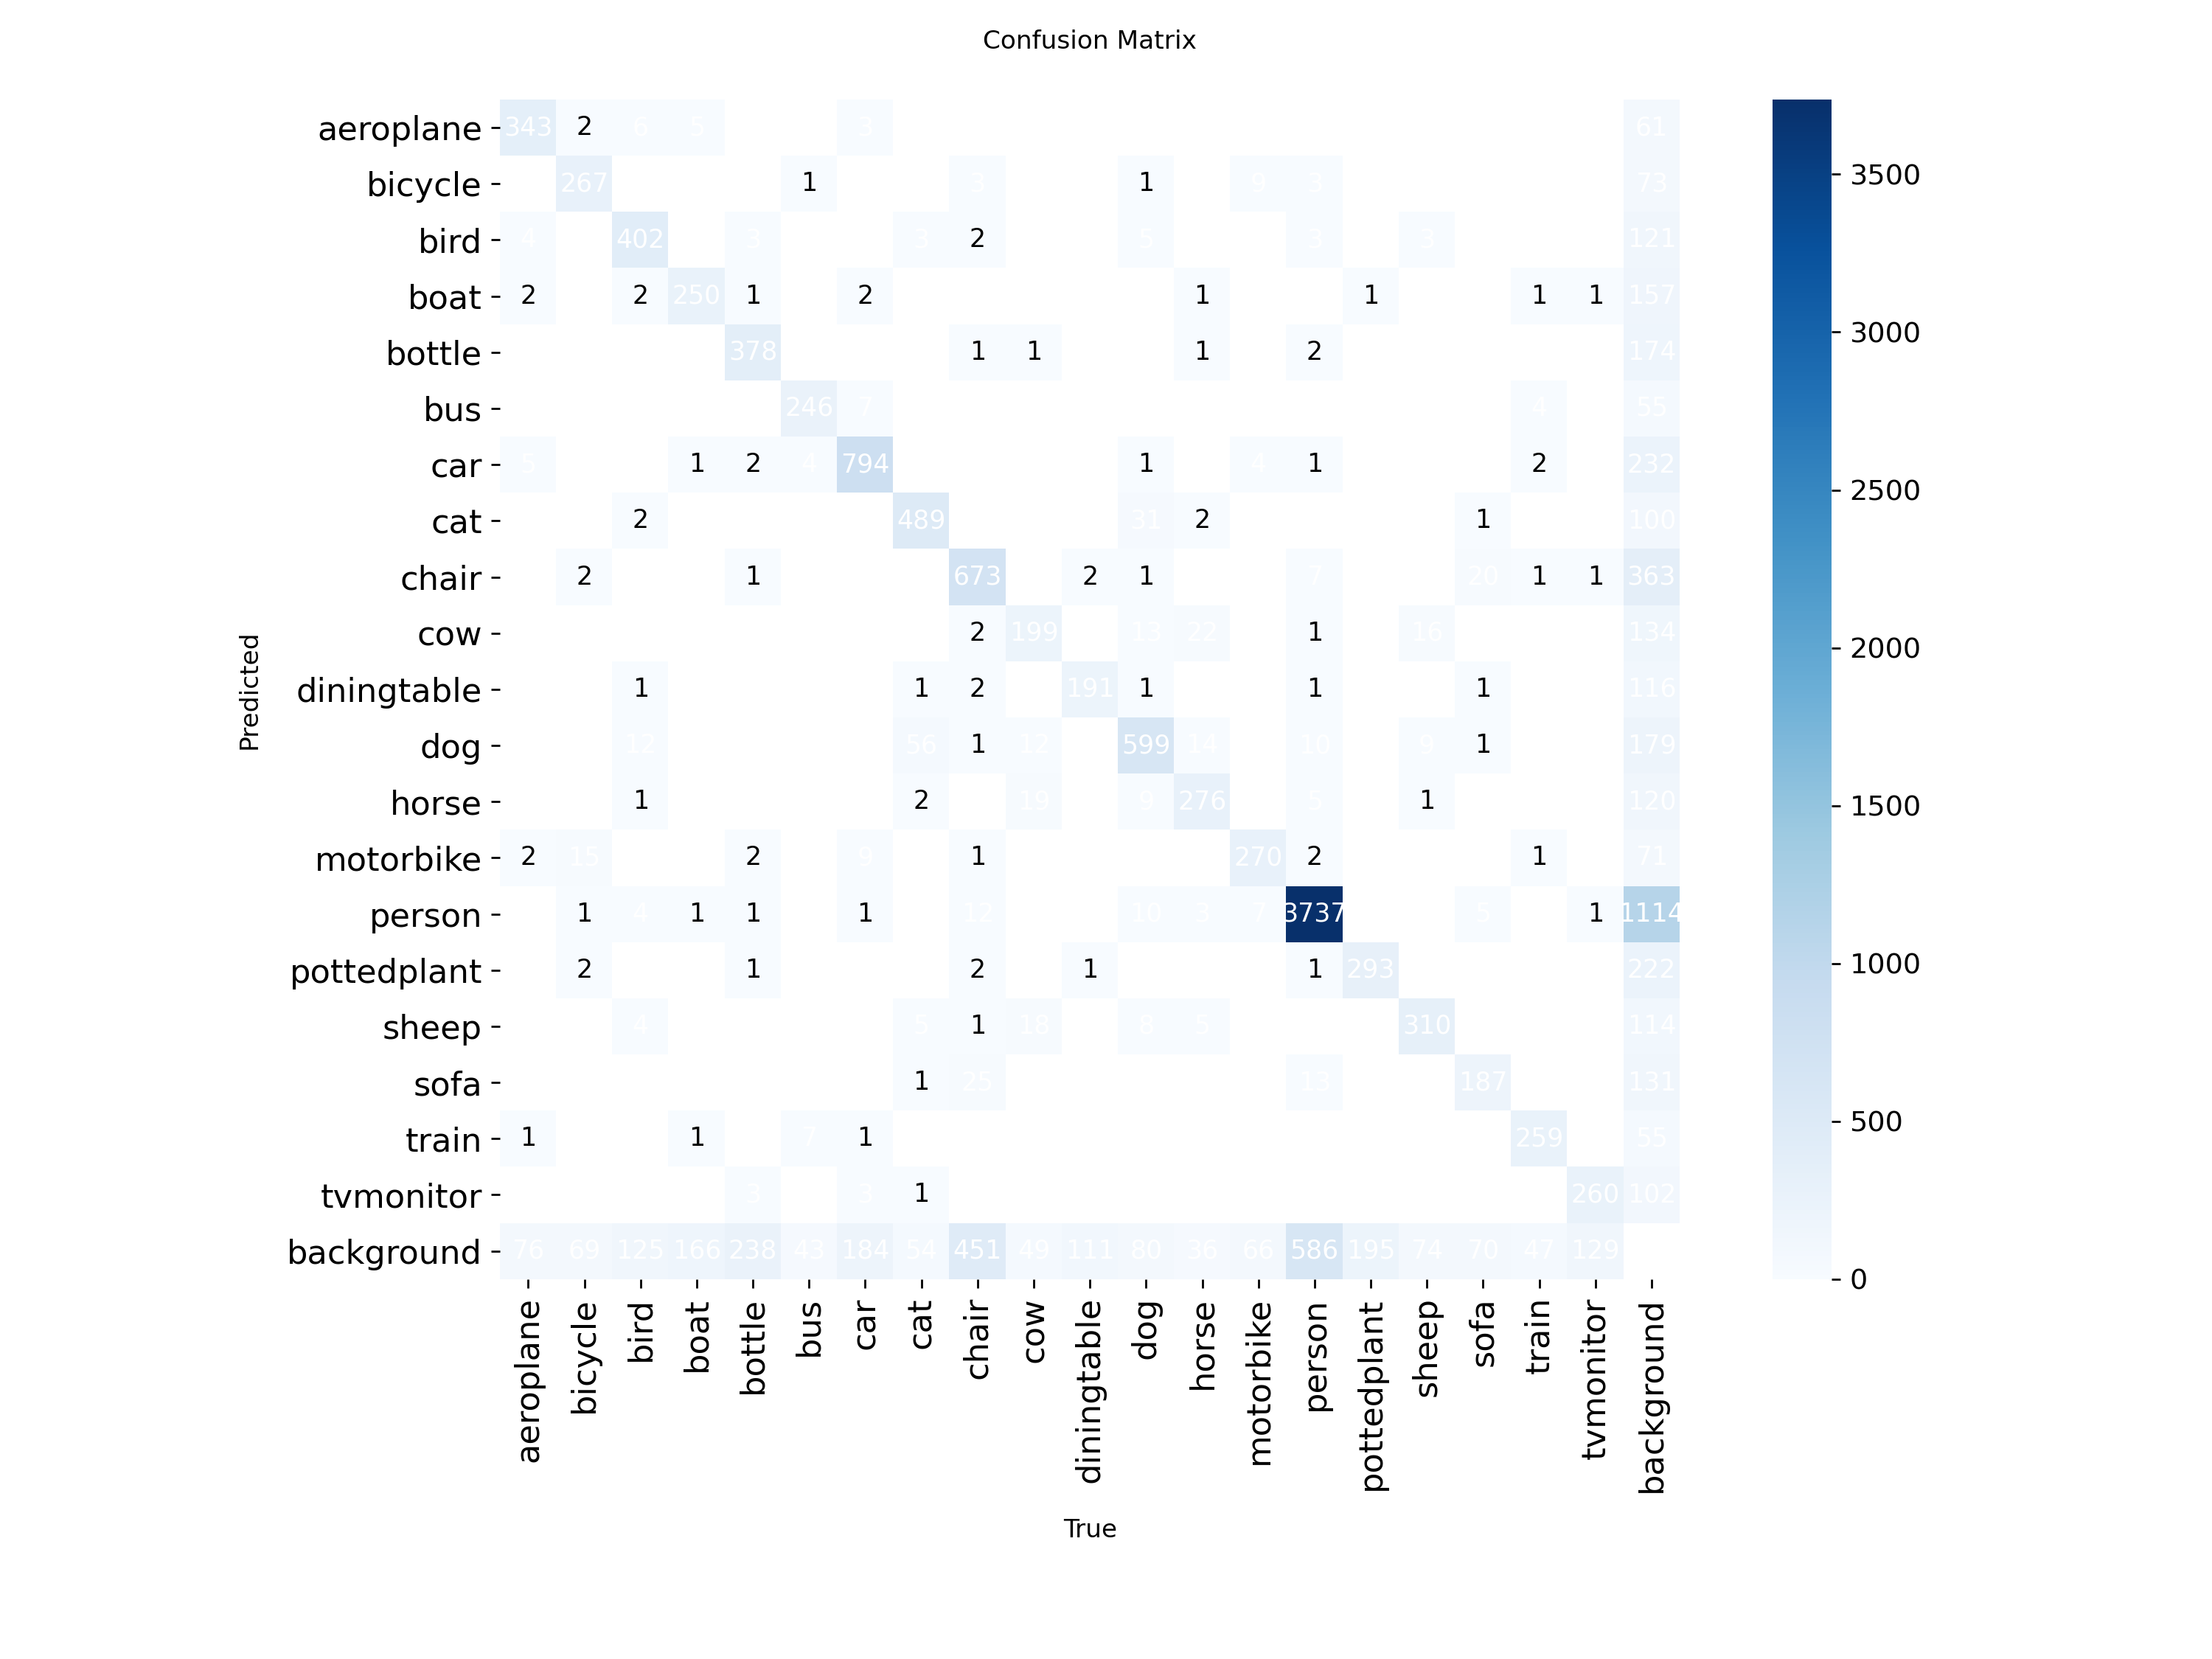

📷 Showing: F1_curve.png


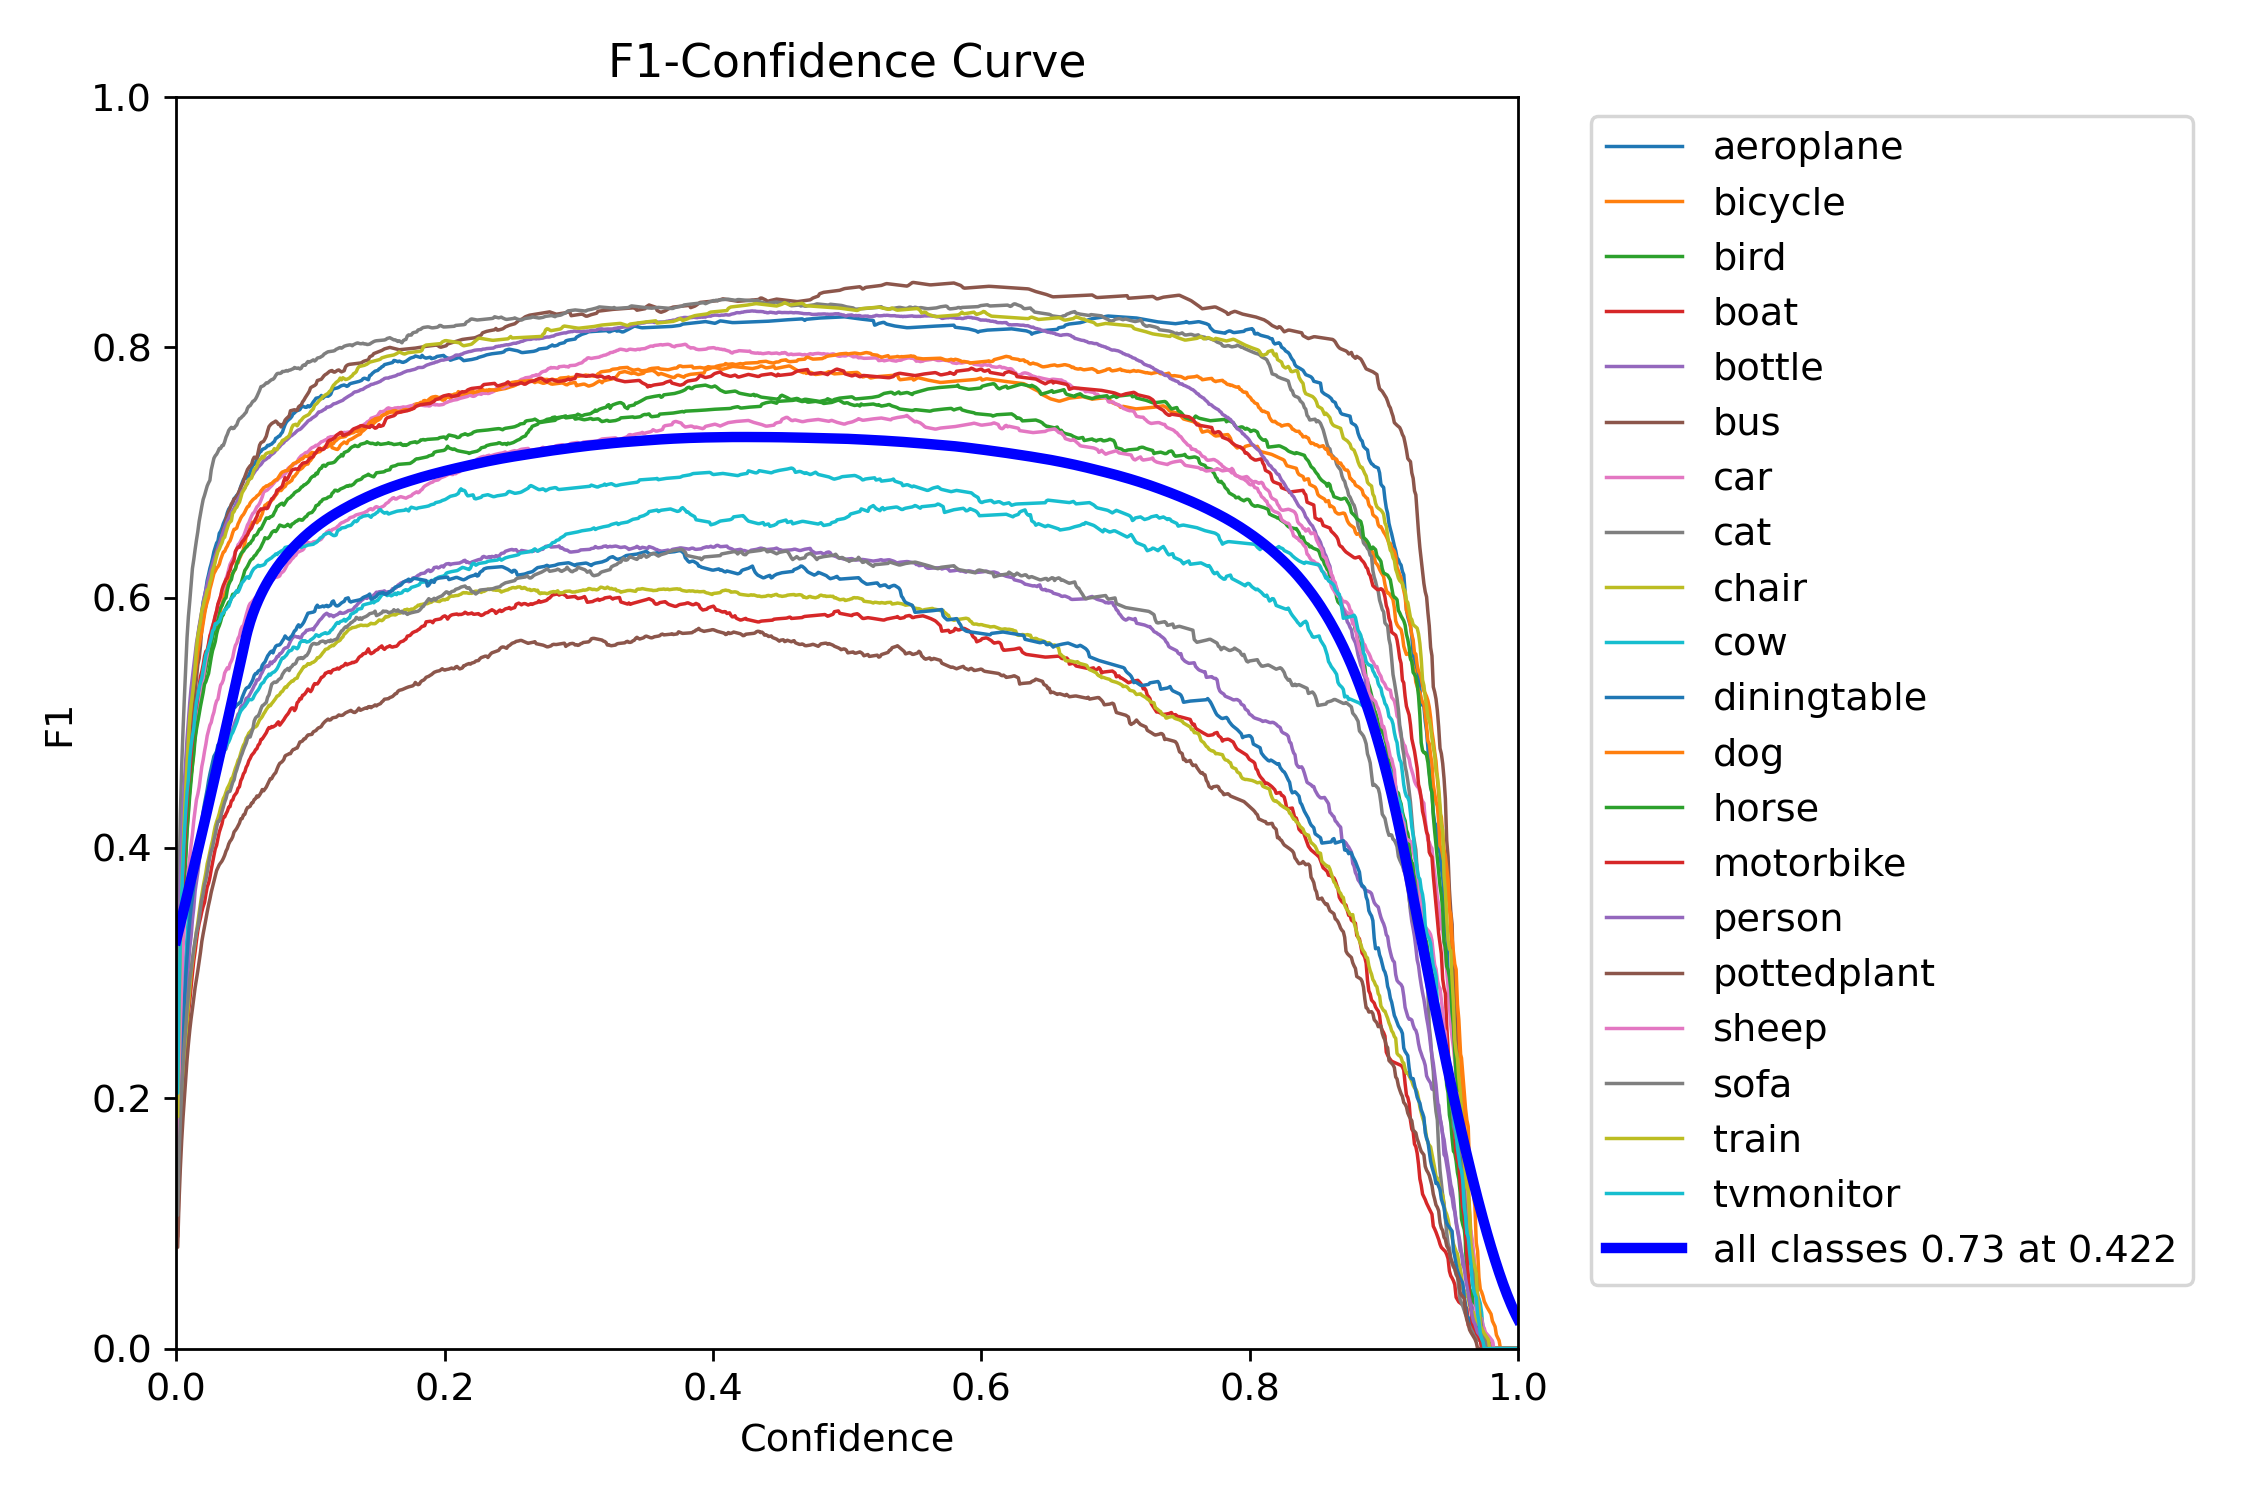

📷 Showing: PR_curve.png


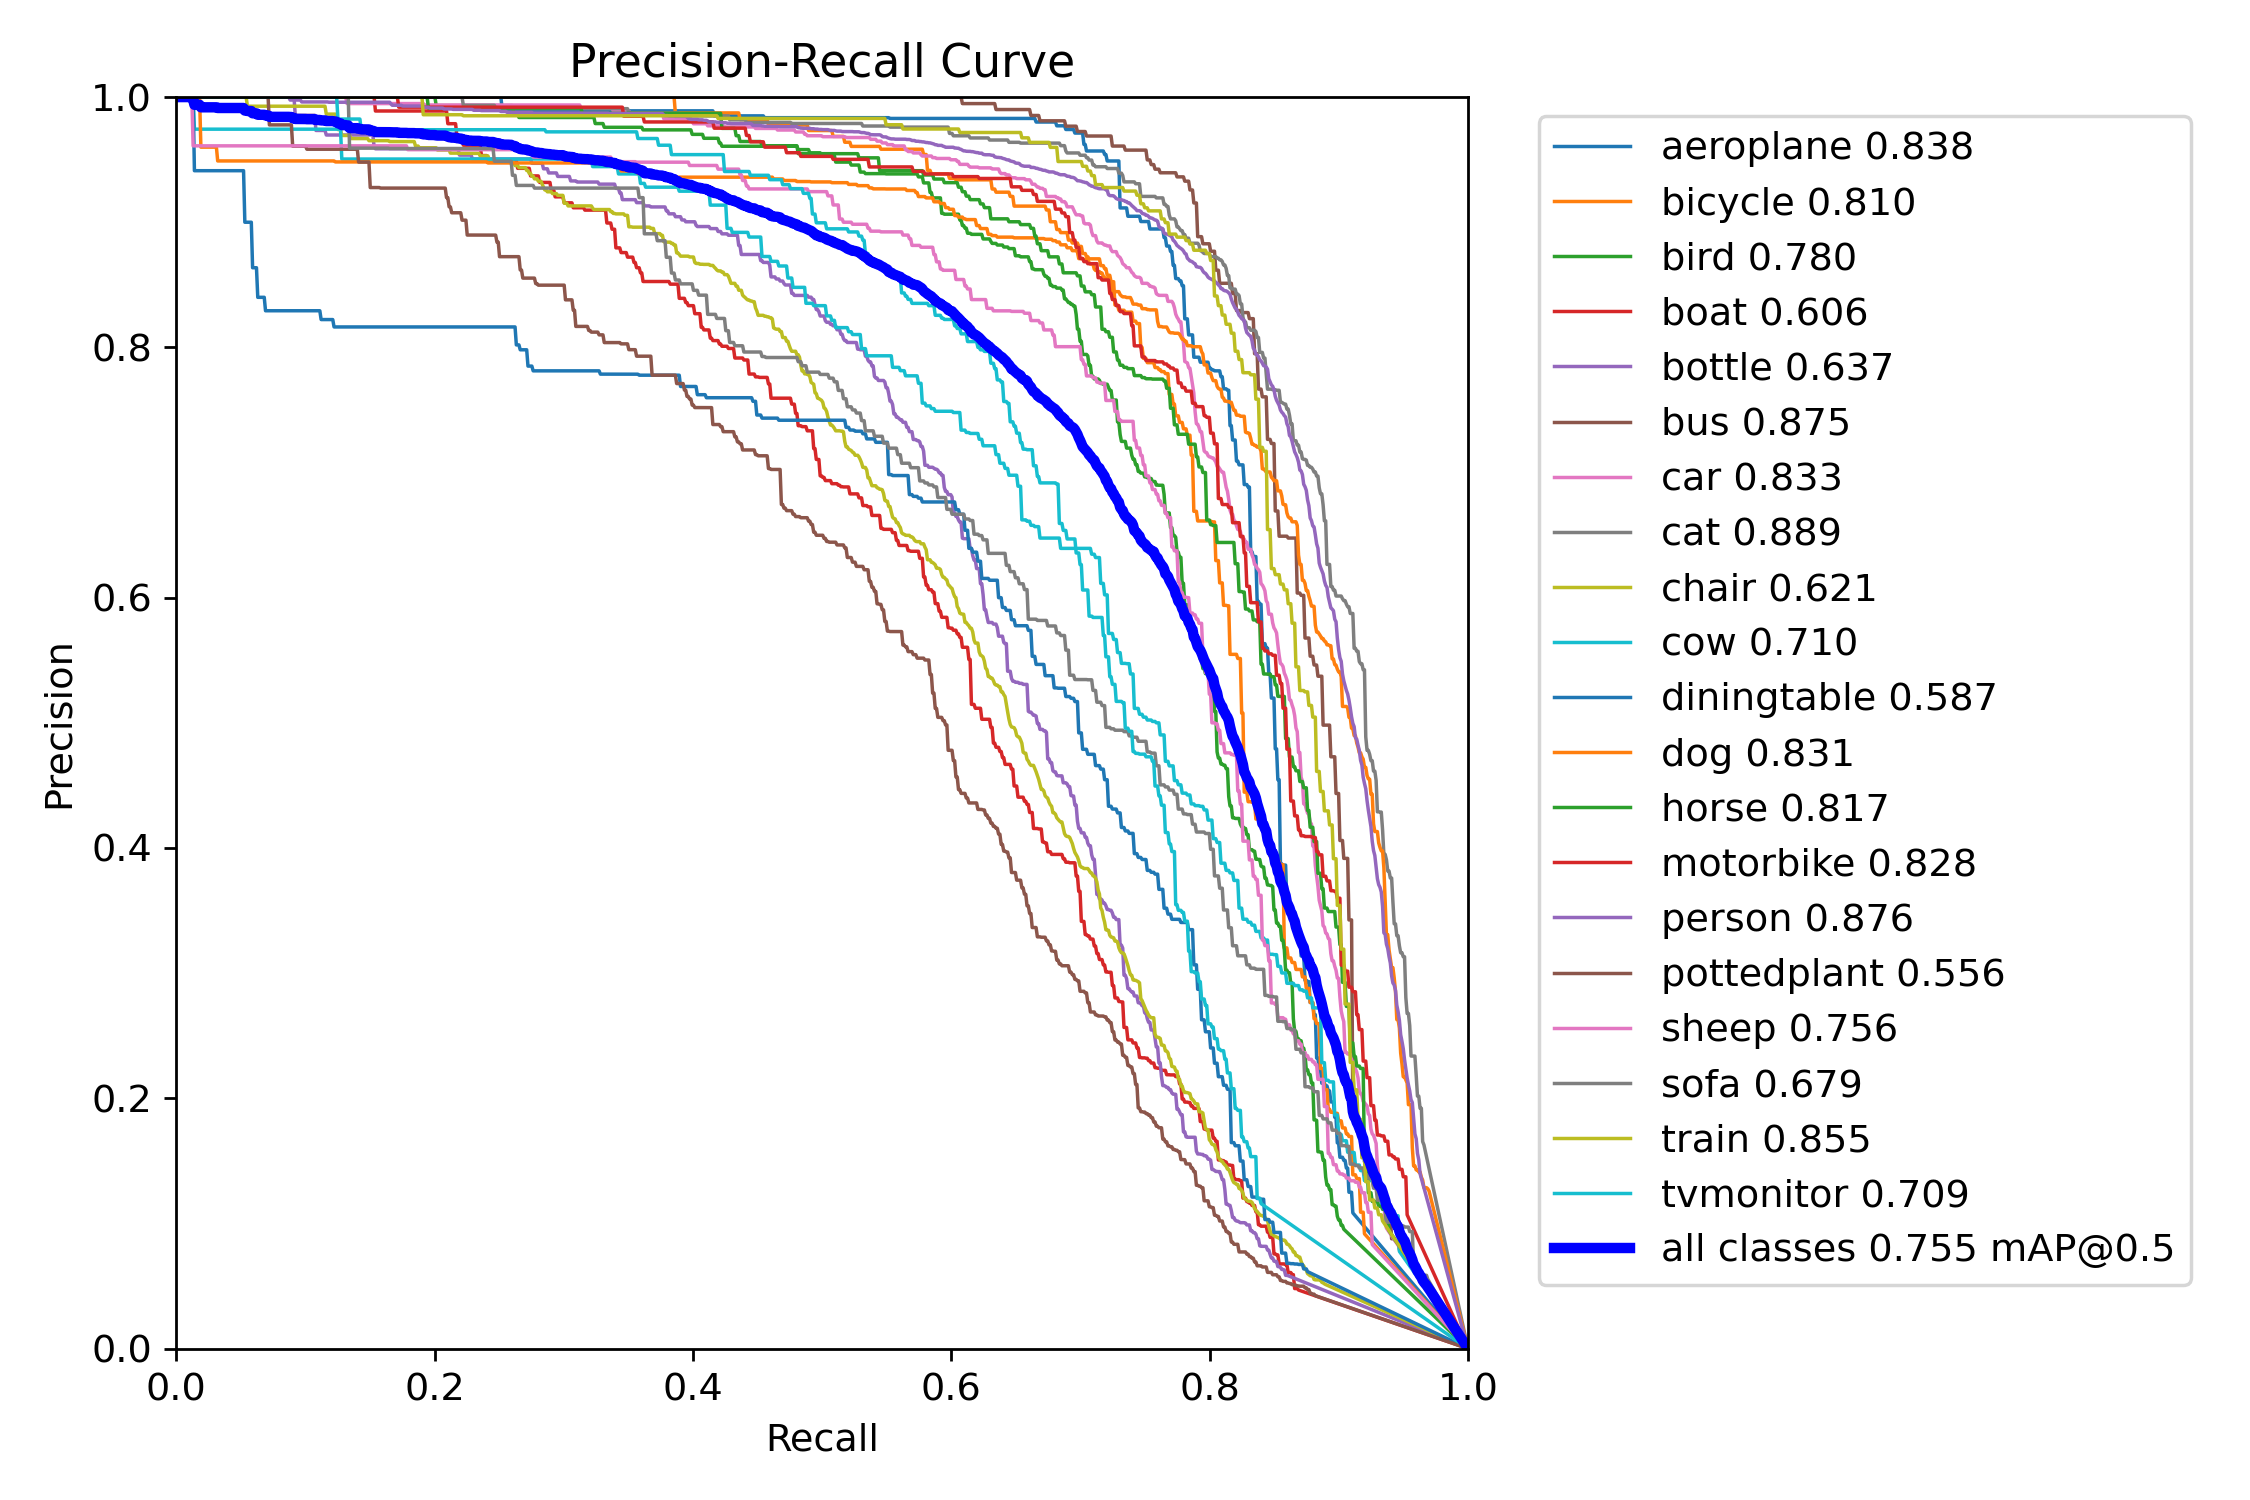

📷 Showing: labels.jpg


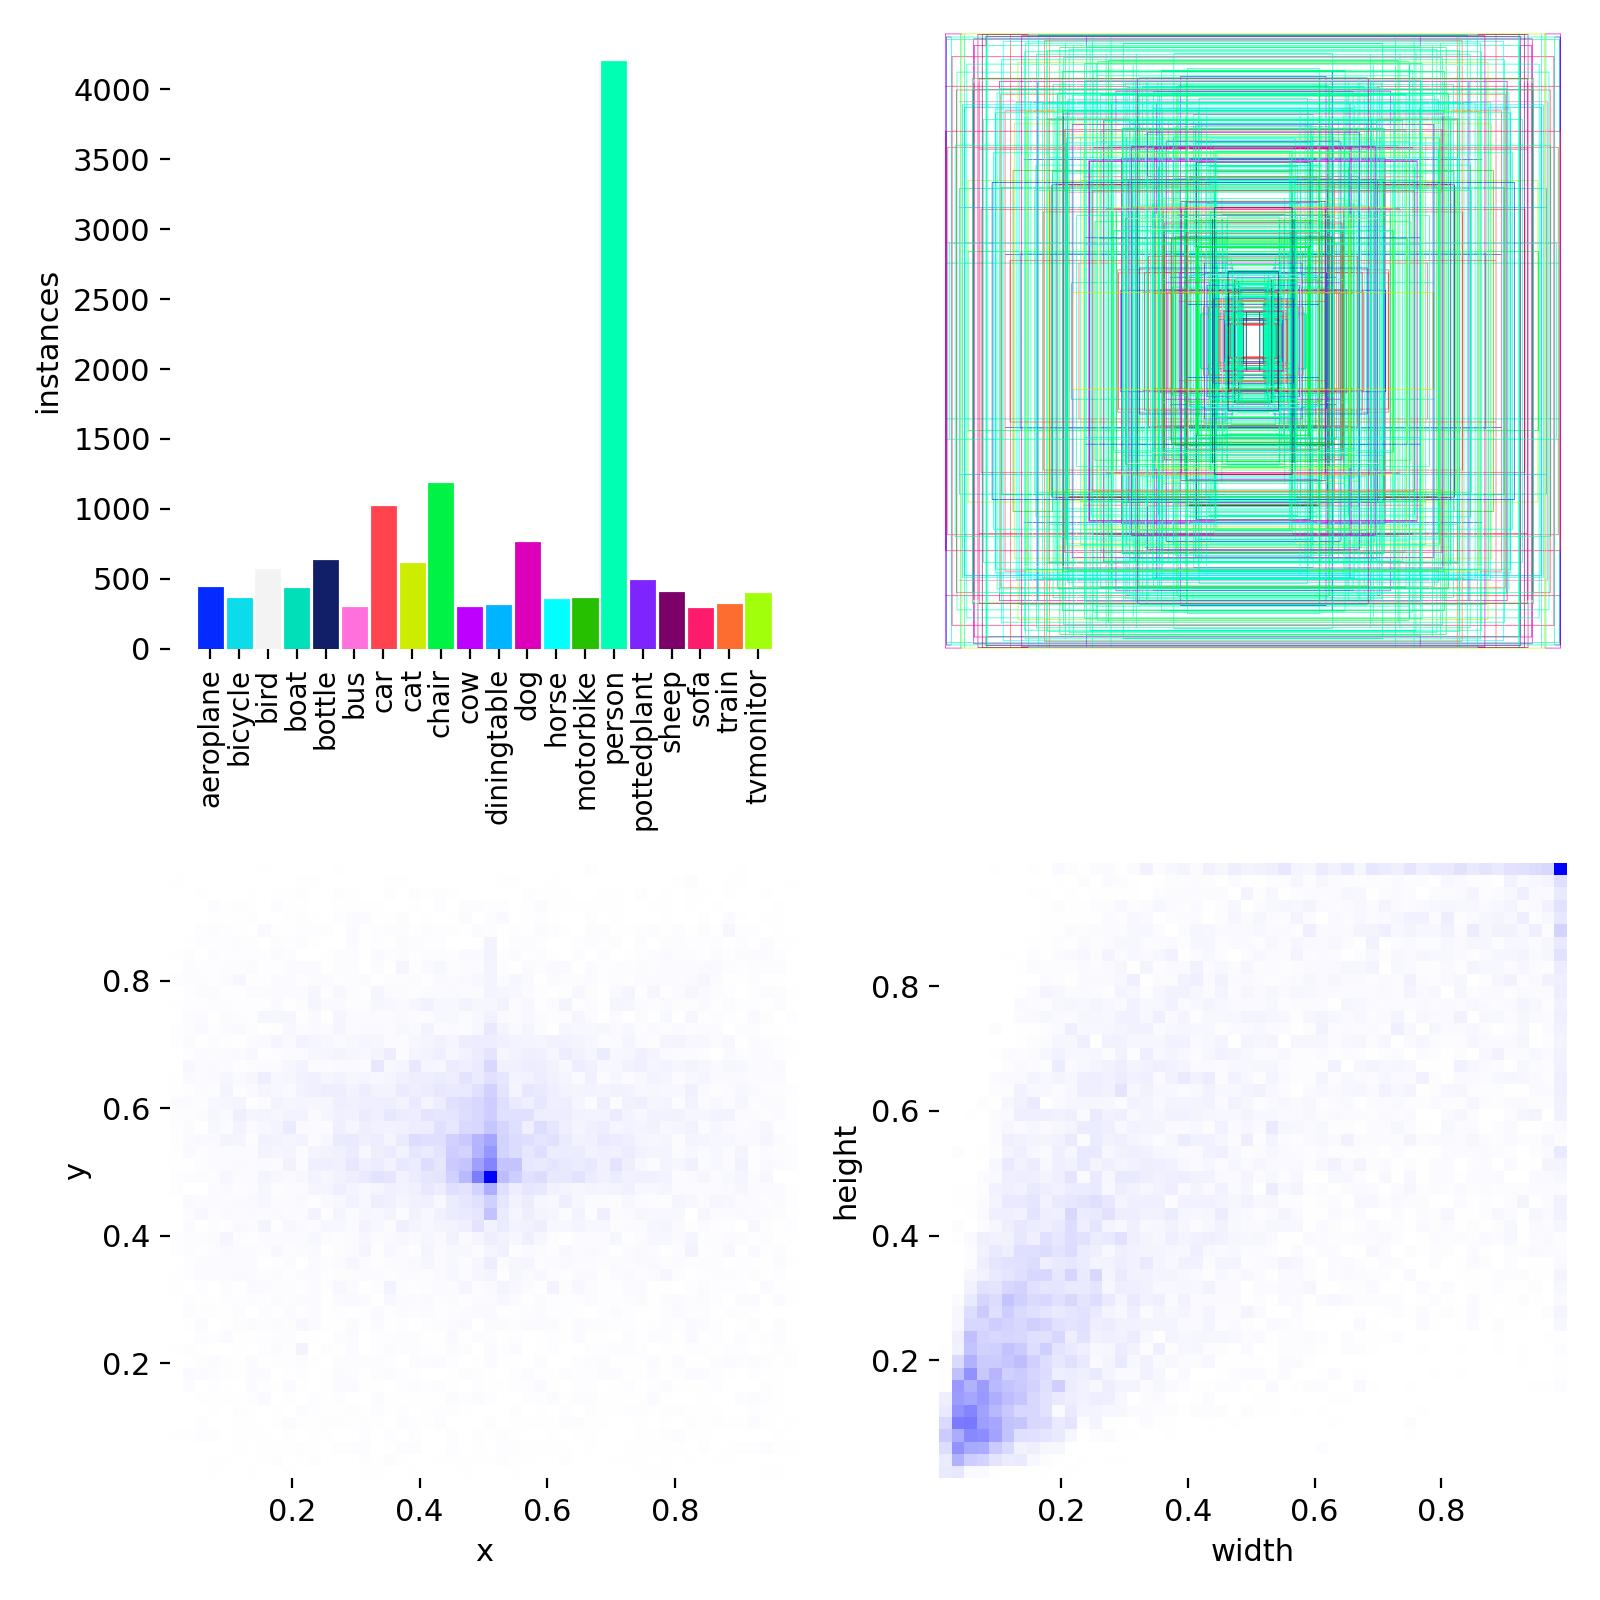

📷 Showing: train_batch0.jpg


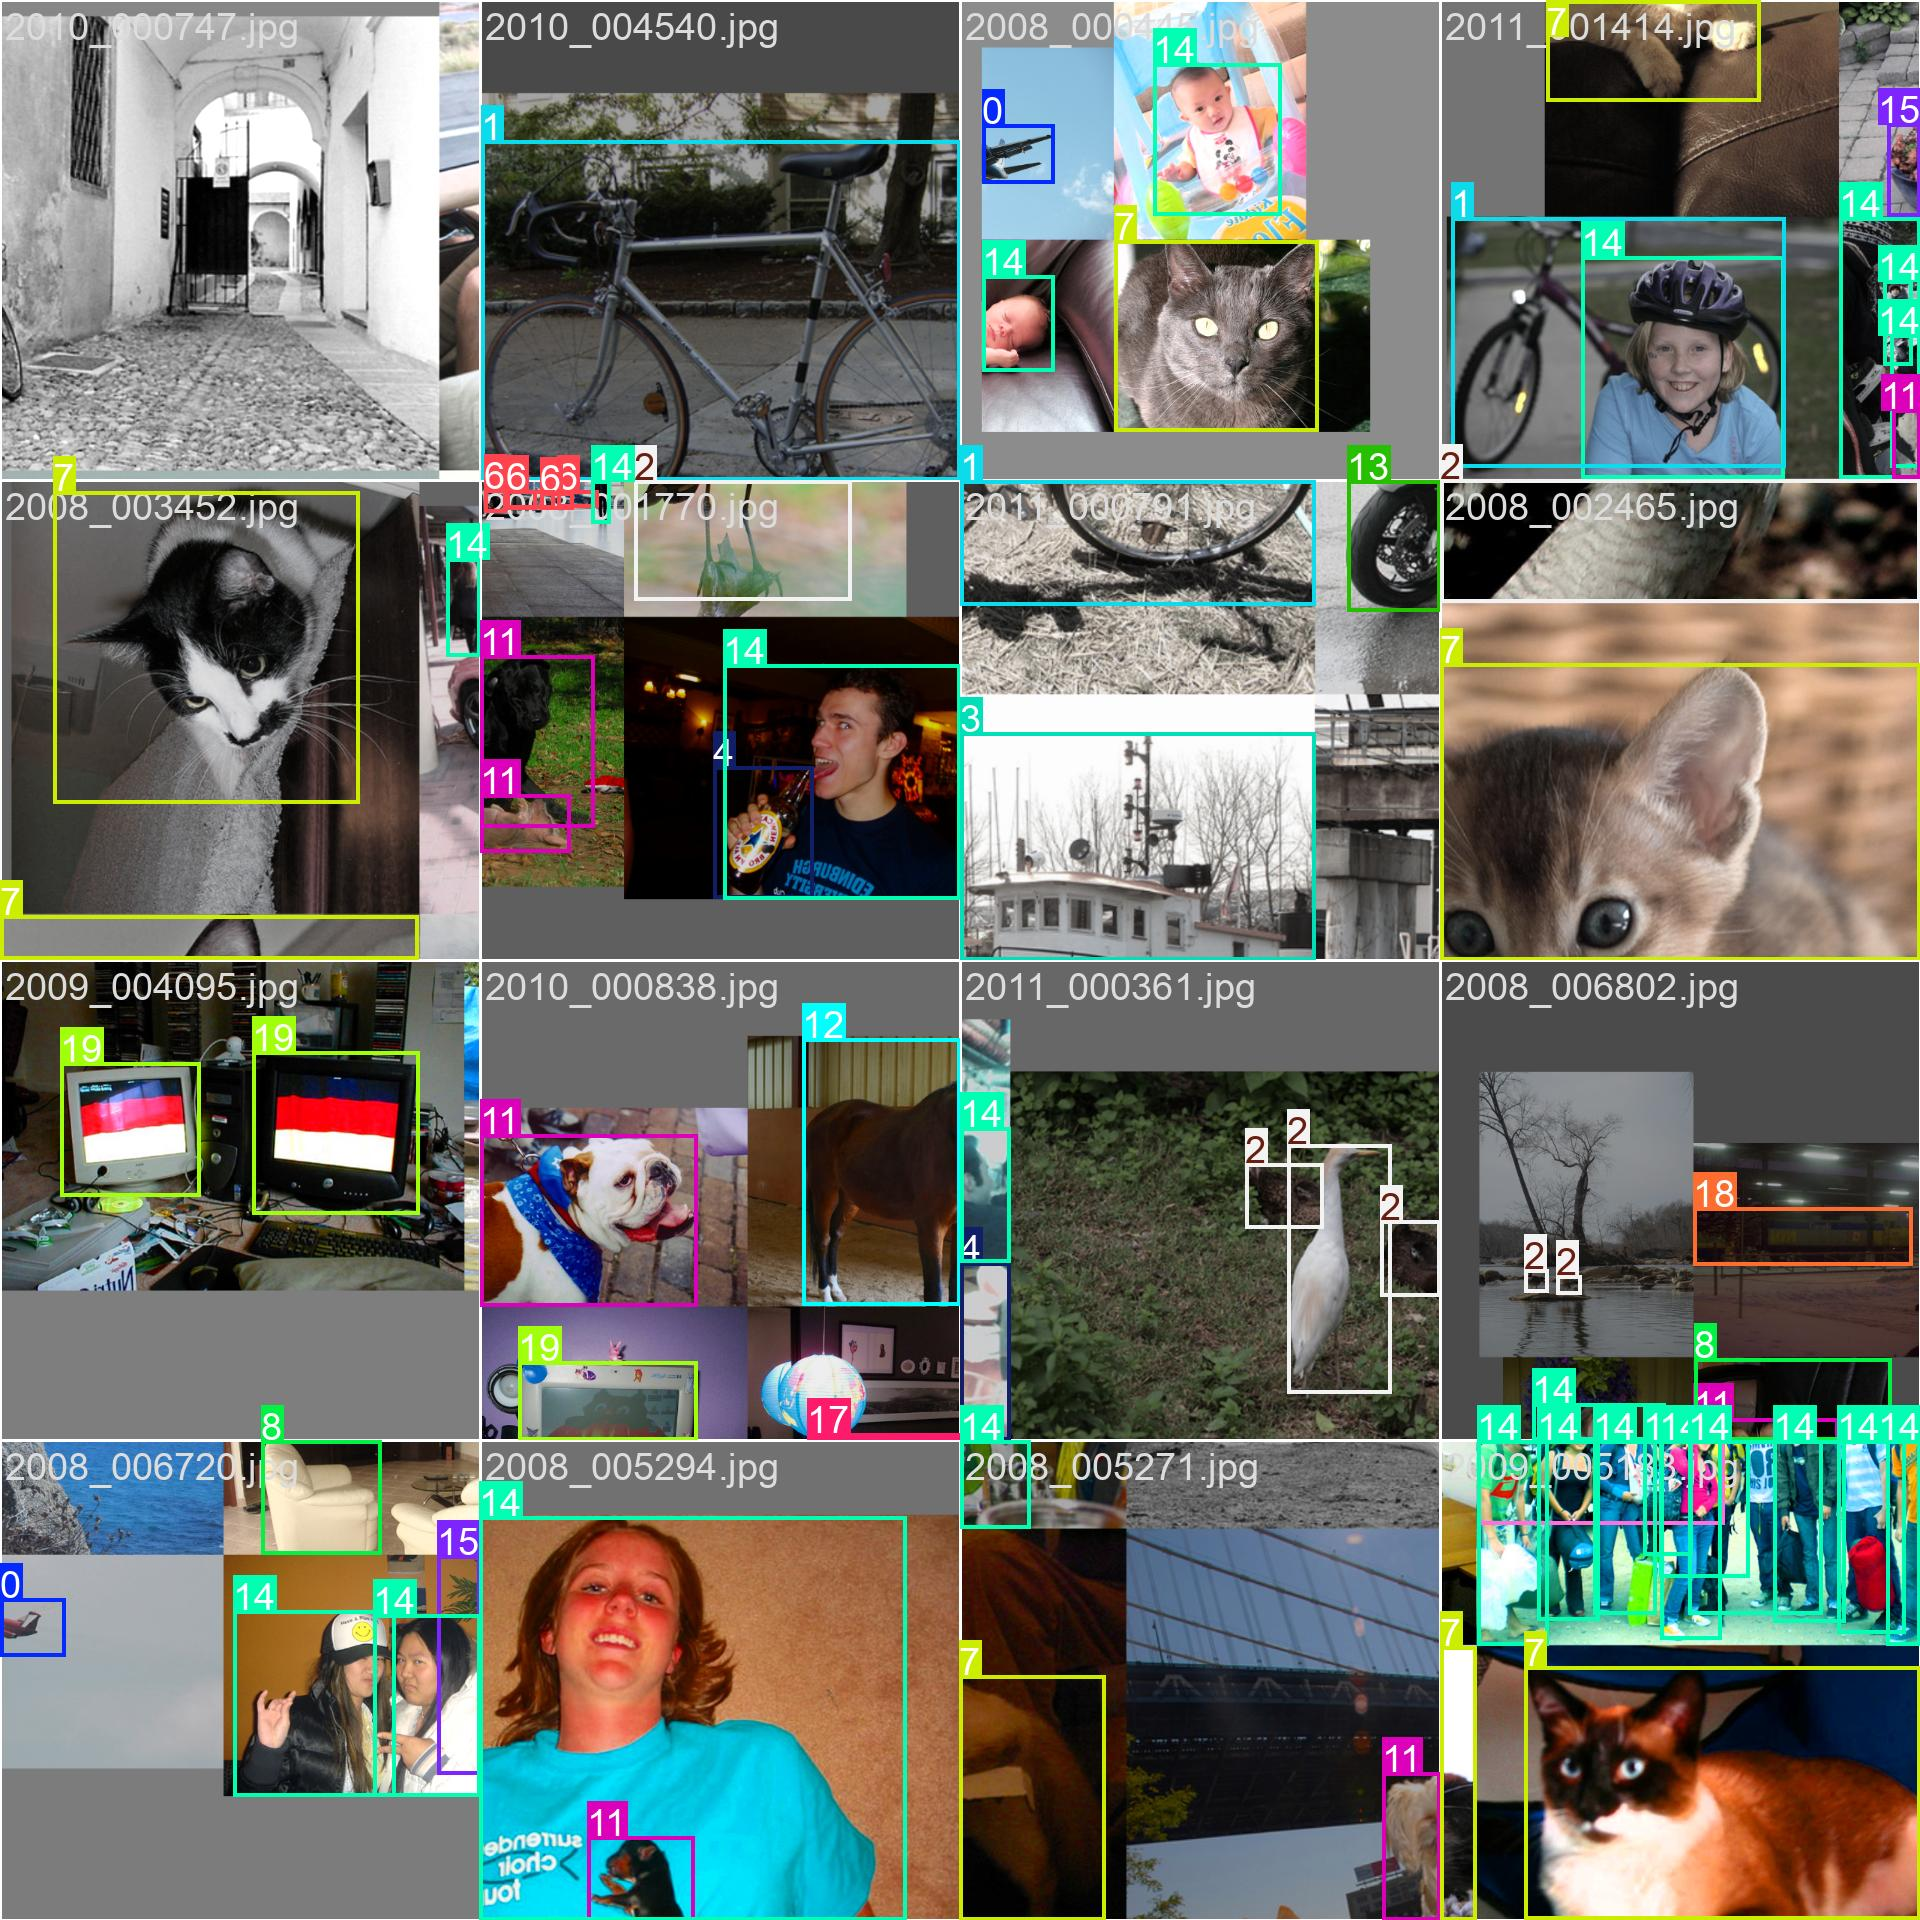

📷 Showing: val_batch0_pred.jpg


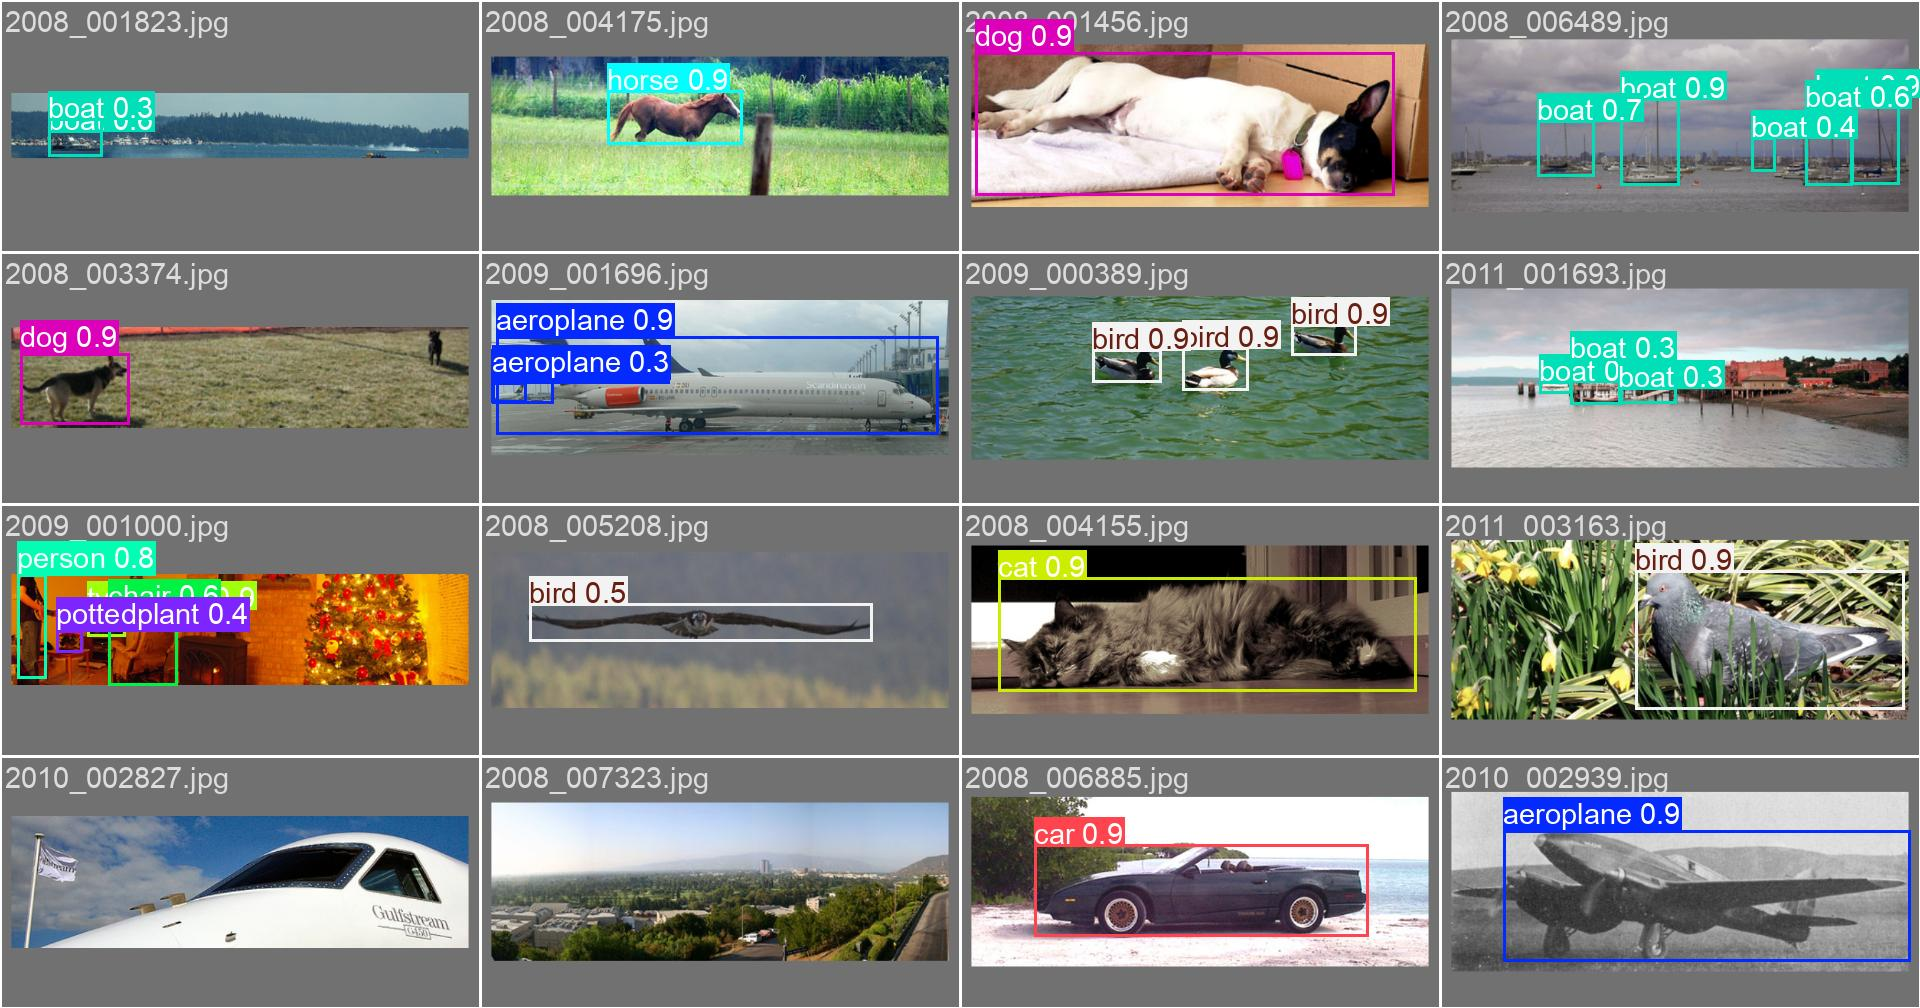

In [11]:
import os
from IPython.display import Image, display

results_dir = "/content/YOLOv8_VOC_FineTune/YOLOv8n_PascalVOC"

image_files = [
    "results.png",
    "confusion_matrix.png",
    "F1_curve.png",
    "PR_curve.png",
    "labels.jpg",
    "train_batch0.jpg",
    "val_batch0_pred.jpg"
]

for img_file in image_files:
    img_path = os.path.join(results_dir, img_file)
    if os.path.exists(img_path):
        print(f"📷 Showing: {img_file}")
        display(Image(filename=img_path, width=600))
    else:
        print(f"❌ Not found: {img_file}")
